In [1]:
import pandas as pd
import numpy as np
import os
import pyaging as pya
import pickle
import scanpy as sc
import seaborn as sns
from scipy.stats import pearsonr
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec # Import gridspec



os.chdir('/mnt/f/MetaAnalysisMethylation')


In [2]:
tableDir = 'output/tables'
figureDir = 'output/figures'
sampleSets = ['PPMI_120', 'PPMI_140', 'GSE145361', 'GSE111629']

# functions

In [3]:
def pairs_statistics(data, condition_col, change_col, group1 = 'Ctrl', group2='PD'):
    from scipy import stats # Import stats module from scipy
    group1_changes = data[data[condition_col] == group1][change_col].dropna()
    group2_changes = data[data[condition_col] == group2][change_col].dropna()
    
    print(f"Number of Ctrl donors: {len(group1_changes)}")
    print(f"Number of PD donors:   {len(group2_changes)}")
    
    if len(group1_changes) < 2 or len(group2_changes) < 2:
        print("\nCannot perform test: Need at least 2 data points per group.")
    else:
        # 2. Check Assumptions (Optional but recommended)
        print("\nChecking assumptions (results printed for info):")
        # Normality Check (Shapiro-Wilk test)
        shapiro_group1_stat, shapiro_group1_p = stats.shapiro(group1_changes)
        shapiro_group2_stat, shapiro_group2_p = stats.shapiro(group2_changes)
        print(f"  Normality (Shapiro-Wilk): Ctrl p-value={shapiro_group1_p:.3f}, PD p-value={shapiro_group2_p:.3f}")
        is_group1_normal = shapiro_group1_p > 0.05
        is_group2_normal = shapiro_group2_p > 0.05
        if not is_group1_normal or not is_group2_normal:
            print("  Note: At least one group may not be normally distributed (p <= 0.05).")
    
        # Equal Variance Check (Levene's test)
        levene_stat, levene_p = stats.levene(group1_changes, group2_changes)
        print(f"  Equal Variance (Levene): p-value={levene_p:.3f}")
        has_equal_variance = levene_p > 0.05
        if not has_equal_variance:
            print("  Note: Variances may not be equal (p <= 0.05).")
    
        # 3. Perform Statistical Test
    
        # --- Option A: Mann-Whitney U Test (Non-parametric, often preferred) ---
        print("\nPerforming Mann-Whitney U test (non-parametric)...")
        # alternative='two-sided' tests if distributions are different
        # alternative='less' tests if Ctrl distribution is stochastically less than PD
        # alternative='greater' tests if Ctrl distribution is stochastically greater than PD
        try:
            u_statistic, p_value_mw = stats.mannwhitneyu(group1_changes, group2_changes, alternative='two-sided')
            print(f"  Mann-Whitney U statistic: {u_statistic:.3f}")
            print(f"  P-value: {p_value_mw:.4f}")
    
            # Interpretation
            alpha = 0.05
            if p_value_mw < alpha:
                print(f"  Result: Significant difference found between Ctrl and PD distributions (p < {alpha}).")
            else:
                print(f"  Result: No significant difference found between Ctrl and PD distributions (p >= {alpha}).")
        except ValueError as e:
             print(f"  Could not perform Mann-Whitney U test: {e}")
    
    
        # --- Option B: Independent Two-Sample T-test (Parametric) ---
        # Choose equal_var based on Levene's test result
        equal_var_assumption = has_equal_variance
        test_type = "Student's t-test" if equal_var_assumption else "Welch's t-test"
        print(f"\nPerforming Independent Two-Sample T-test ({test_type}, parametric)...")
        if not is_group1_normal or not is_group2_normal:
             print("  Warning: Data may not be normally distributed; interpret t-test results with caution.")
    
        try:
            t_statistic, p_value_ttest = stats.ttest_ind(group1_changes, group2_changes, equal_var=equal_var_assumption, nan_policy='omit')
            print(f"  T-statistic: {t_statistic:.3f}")
            print(f"  P-value: {p_value_ttest:.4f}")
    
            # Interpretation
            alpha = 0.05
            if p_value_ttest < alpha:
                print(f"  Result: Significant difference found between Ctrl and PD means (p < {alpha}).")
            else:
                print(f"  Result: No significant difference found between Ctrl and PD means (p >= {alpha}).")
        except Exception as e:
            print(f"  Could not perform t-test: {e}")
    
    
        print("\n--- Interpretation Guidance ---")
        print("Choose the test result based on assumptions:")
        print("- If data is NOT normally distributed (especially with small N), prefer Mann-Whitney U.")
        print("- If data IS normally distributed:")
        print("  - Use T-test result.")
        print("  - If variances were unequal (Levene p <= 0.05), Welch's t-test (equal_var=False) was used.")
        print("  - If variances were equal (Levene p > 0.05), Student's t-test (equal_var=True) was used.")
        print(f"A p-value below alpha (typically 0.05) indicates a statistically significant difference.")


# Load datasets

In [ ]:
all_data = {}
for sampleSet in sampleSets:
    # Construct the full file paths
    phenotype_path = os.path.join(tableDir, f"{sampleSet}_sample_phenotype.csv")
    beta_values_path = os.path.join(tableDir, f"{sampleSet}_beta_values.tsv.gz")

    # Load the three files directly
    phenotype_df = pd.read_csv(phenotype_path)
    beta_df = pd.read_csv(beta_values_path, sep='\t', index_col=0)

    # Store the loaded DataFrames in the main dictionary
    all_data[sampleSet] = {
        'phenotype': phenotype_df,
        'betas': beta_df
    }
del phenotype_path, beta_values_path, phenotype_df, beta_df

In [ ]:
file_path = os.path.join('output', 'betas_pheno.pkl')
pickle.dump(all_data, open(file_path, "wb"))

In [6]:
#file_path = os.path.join('output', 'betas_pheno.pkl')
#all_data = pickle.load(open(file_path, "rb"))

## Process pheno

In [7]:
gender_map = {'Male': 'M', 'Female': 'F'}

In [8]:
all_data['GSE145361']['phenotype']['ID'] = 'GSE145361' + '_' + all_data['GSE145361']['phenotype']['Sample_Name'].astype(str) + '_' + all_data['GSE145361']['phenotype']['Raw_Name'].astype(str)
all_data['GSE145361']['phenotype'].rename(columns={'age': 'Age'}, inplace=True)
all_data['GSE145361']['phenotype']['Gender'].replace(gender_map, inplace=True)
all_data['GSE145361']['phenotype']['Name'] = all_data['GSE145361']['phenotype']['Sample_Name'].copy()

/tmp/ipykernel_499/2352799079.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['GSE145361']['phenotype']['Gender'].replace(gender_map, inplace=True)


In [9]:
all_data['GSE111629']['phenotype']['ID'] = 'GSE111629' + '_' + all_data['GSE111629']['phenotype']['Sample_Name'].astype(str) + '_' + all_data['GSE111629']['phenotype']['Raw_Name'].astype(str)
all_data['GSE111629']['phenotype'].rename(columns={'age': 'Age'}, inplace=True)
all_data['GSE111629']['phenotype']['Gender'].replace(gender_map, inplace=True)
all_data['GSE111629']['phenotype']['Name'] = all_data['GSE111629']['phenotype']['Sample_Name'].copy()

/tmp/ipykernel_499/503858990.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_data['GSE111629']['phenotype']['Gender'].replace(gender_map, inplace=True)


In [10]:
all_data['PPMI_140']['phenotype']['ID'] = 'PPMI_140' + '_' + all_data['PPMI_140']['phenotype']['SENTRIXID'].astype(str) + '_' + all_data['PPMI_140']['phenotype']['POSITION'].astype(str)
all_data['PPMI_140']['phenotype']['Name'] = all_data['PPMI_140']['phenotype']['PATNO'].copy()
all_data['PPMI_140']['phenotype'].loc[all_data['PPMI_140']['phenotype']['Condition_sub'] == 'fPD', 'Condition'] = "familial Parkinson's disease"

In [11]:
all_data['PPMI_120']['phenotype']['ID'] = 'PPMI_120' + '_' + all_data['PPMI_120']['phenotype']['SENTRIXID'].astype(str) + '_' + all_data['PPMI_120']['phenotype']['POSITION'].astype(str)
all_data['PPMI_120']['phenotype'].loc[all_data['PPMI_120']['phenotype']['Condition_sub'] == 'fPD', 'Condition'] = "familial Parkinson's disease"
all_data['PPMI_120']['phenotype']['Name'] = all_data['PPMI_120']['phenotype']['PATNO'].copy()

In [12]:
all_data['PPMI_120']['phenotype'].Condition_sub.unique()

array(['sPD', 'Control'], dtype=object)

In [13]:
pheno = []
keep = ['ID', 'Name', 'Set', 'Condition', 'Age', 'Gender', 'EVENT_ID']
for sampleSet in sampleSets:
    pheno_df = all_data[sampleSet]['phenotype'].copy()
    if 'EVENT_ID' not in pheno_df.columns:
        pheno_df['EVENT_ID'] = 'BL'
    pheno_df['Set'] = sampleSet
    pheno_df = pheno_df[keep]
    pheno.append(pheno_df)
del pheno_df

In [14]:
pheno = pd.concat(pheno, ignore_index=True)

## Process betas

In [15]:
beta_dfs = []
for sampleSet in sampleSets:
    beta_df = all_data[sampleSet]['betas'].copy()
    beta_df.columns = [f"{sampleSet}_{col}" for col in beta_df.columns]
    beta_dfs.append(beta_df)
del beta_df

In [16]:
del all_data

In [17]:
data = pd.concat(beta_dfs, axis=1)
del beta_dfs

## Adjust for pyaging

In [18]:
# Adjust shape for pyaging input
data = data.transpose()

In [19]:
# Split Probe_IDs and average IDs for same positions
data = pya.pp.epicv2_probe_aggregation(data)

|-----> 🏗️ Starting epicv2_probe_aggregation function
|-----> ⚙️ Looking for duplicated probes started
|-----------> in progress: 100.0000%
|-----------> There are no duplicated probes. Returning original data
|-----> 🎉 Done! [25.1750s]


In [20]:
gender_map = {'F': 1, 'M': 0}
pheno['female'] = pheno['Gender'].map(gender_map).copy()

In [21]:
pheno['Homo sapiens'] = 1

In [22]:
# Inner join: only keep rows where index is in both data and pheno
pheno = pheno.set_index("ID")
data = data.merge(pheno, left_index=True, right_index=True, how='inner')

In [23]:
column_pheno = list(pheno.columns)

In [24]:
column_pheno

['Name',
 'Set',
 'Condition',
 'Age',
 'Gender',
 'EVENT_ID',
 'female',
 'Homo sapiens']

# Running the clock

In [25]:
adatas = {
    sampleSet: pya.pp.df_to_adata(
        data[data['Set'] == sampleSet], 
        metadata_cols=column_pheno, 
        imputer_strategy='knn'
    ) 
    for sampleSet in sampleSets
}

|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----------? Dropping 37805 columns with only NAs: ['cg09499020', 'cg25610492', 'cg10583942'], etc.
|-----> ⚠️ Create anndata object finished [1.3749s]
|-----> ⚙️ Add metadata to anndata started
|-----------> Adding provided metadata to adata.obs
|-----> ✅ Add metadata to anndata finished [0.0027s]
|-----> ⚙️ Log data statistics started
|-----------> There are 159 observations
|-----------> There are 725442 features
|-----------> Total missing values: 0
|-----------> Percentage of missing values: 0.00%
|-----> ✅ Log data statistics finished [0.1263s]
|-----> ⚙️ Impute missing values started
|-----------> No missing values found. No imputation necessary
|-----> ✅ Impute missing values finished [0.1492s]
|-----> 🎉 Done! [2.9315s]
|-----> 🏗️ Starting df_to_adata function
|-----> ⚙️ Create anndata object started
|-----------? Dropping 28047 columns with only NAs: ['cg06981504', 'cg13246026', 'cg09828226'], e

In [26]:
del data

In [27]:
clocks = ['Horvath2013', 'AltumAge', 'PCGrimAge', 'GrimAge2', 'DunedinPACE']

In [28]:
for sampleSet in sampleSets:
    for clock in clocks:
        try:
            pya.pred.predict_age(adatas[sampleSet], clock)
        except:
            pass

|-----> 🏗️ Starting predict_age function
|-----> ⚙️ Set PyTorch device started
|-----------> Using device: cuda
|-----> ✅ Set PyTorch device finished [0.0024s]
|-----> 🕒 Processing clock: horvath2013
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/horvath2013.pt
|-----------> ✅ Load clock finished [0.6440s]
|-----------> ⚙️ Check features in adata started
|-----------------? 27 out of 353 features (7.65%) are missing: ['cg01873645', 'cg02654291', 'cg02972551'], etc.
|-----------------> Using reference feature values for horvath2013
|-----------> ⚠️ Check features in adata finished [0.4074s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is anti_log_linear
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages with model finished [0.2380s]
|-----------> ⚙️ Add predicted ages and clock metadata to adata started
|-----------> ✅ Add pre

In [29]:
file_path = os.path.join("output", "adatas_clock.pkl")
pickle.dump(adatas, open(file_path, "wb"))

In [30]:
list_obs = []
for sampleSet in sampleSets:
    obs_df = adatas[sampleSet].obs.copy()
    list_obs.append(obs_df)
    

data_clock = pd.concat(list_obs)
del list_obs, obs_df


In [31]:
file_path = os.path.join(tableDir, 'df_clock.xlsx')
data_clock.to_excel(file_path)

# Visualization

In [5]:
file_path = os.path.join(tableDir, 'df_clock.xlsx')
data_clock = pd.read_excel(file_path, index_col=0)

In [6]:
data_clock_backup = data_clock.copy()

In [7]:
data_clock = data_clock[data_clock['EVENT_ID'] == 'BL'].copy()

In [8]:
data_clock['label'] = data_clock.index.copy()

In [9]:
data_clock.columns

Index(['Name', 'Set', 'Condition', 'Age', 'Gender', 'EVENT_ID', 'female',
       'Homo sapiens', 'horvath2013', 'altumage', 'pcgrimage', 'grimage2',
       'dunedinpace', 'label'],
      dtype='object')

In [10]:
data_clock['Name'] = data_clock['Name'].astype('str')
data_clock['Condition'] = data_clock['Condition'].astype('category')
data_clock['Age'] = data_clock['Age'].astype('float64')

In [11]:
# Identify column names 
actual_age_col = 'Age'
condition_col = 'Condition'
timepoint_col = 'EVENT_ID'
donor_col = 'Name'
clock_cols = list(data_clock.columns[8:13])

In [12]:
clock_cols

['horvath2013', 'altumage', 'pcgrimage', 'grimage2', 'dunedinpace']

In [13]:
condition_color = {'Control': 'darkblue', "Parkinson's disease": 'red', 'Prodromal': 'darkgreen', "familial Parkinson's disease": 'salmon'}

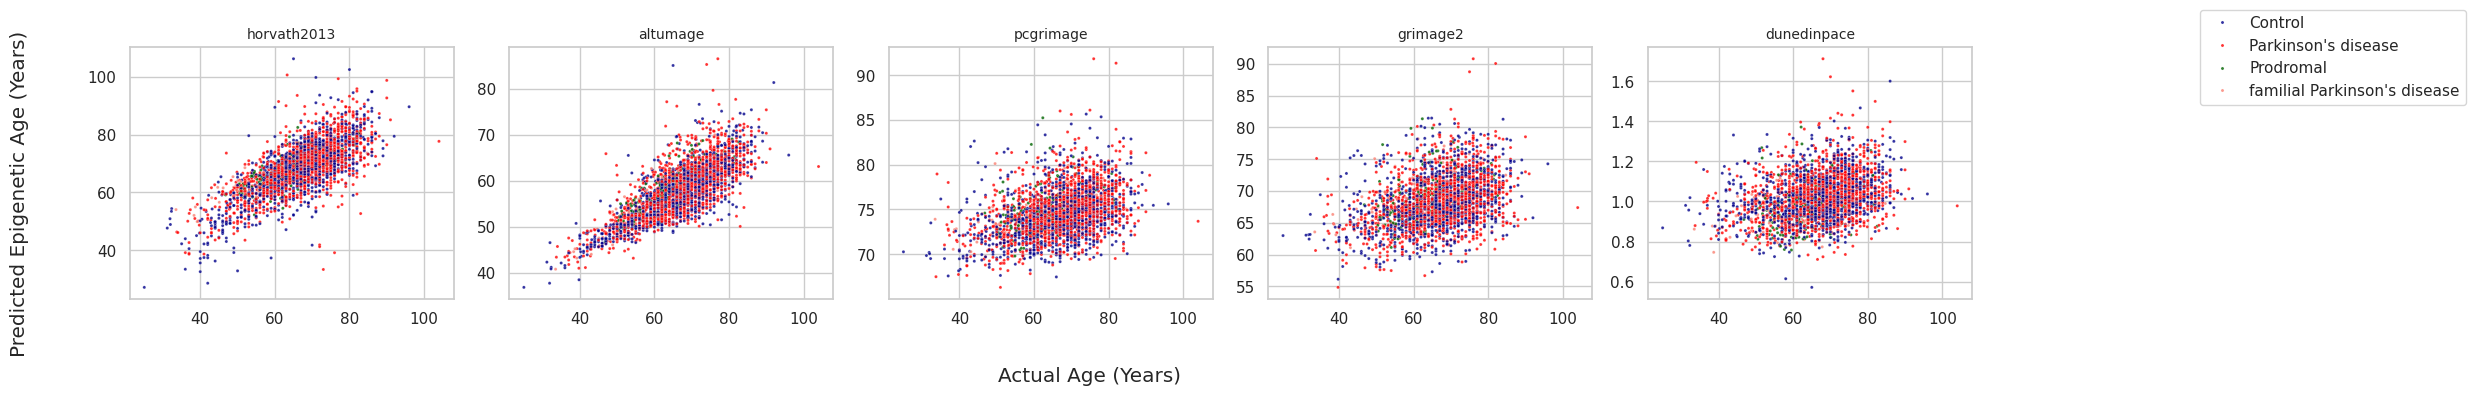

In [14]:

# Set plot style
sns.set_theme(style="whitegrid")

legend_handles = None 
legend_labels = None


ncols = 5
num_clocks = len(clock_cols)
nrows = math.ceil(num_clocks / ncols)
# --- Create Subplots Grid ---
fig_scatter, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4.5, nrows * 4), sharex=False, sharey=False) # Use sharex=False now
axes_flat = axes.flatten()

for i, clock in enumerate(clock_cols):
    ax = axes_flat[i]
    create_legend = (i == 0)

    sns.scatterplot(
        data=data_clock,
        x=actual_age_col,
        y=clock,
        hue=condition_col,
        #hue_order=label_order,
        palette=condition_color,
        ax=ax,
        s=5,
        alpha=0.8,
        legend='full' if create_legend else False 
    )

    if create_legend:
        legend_handles, legend_labels = ax.get_legend_handles_labels()
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    ax.set_title(f'{clock}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig_scatter.supxlabel('Actual Age (Years)', y=0.02)
fig_scatter.supylabel('Predicted Epigenetic Age (Years)', x=0.02)

for j in range(num_clocks, nrows * ncols):
    axes_flat[j].set_visible(False)

if legend_handles and legend_labels:
    fig_scatter.legend(
        legend_handles,
        legend_labels,
        bbox_to_anchor=(0.99, 0.98), 
        loc='upper left',           
        ncol=1                      
     )

plt.tight_layout(rect=[0.03, 0.03, 0.90, 0.96]) 
plt.show()


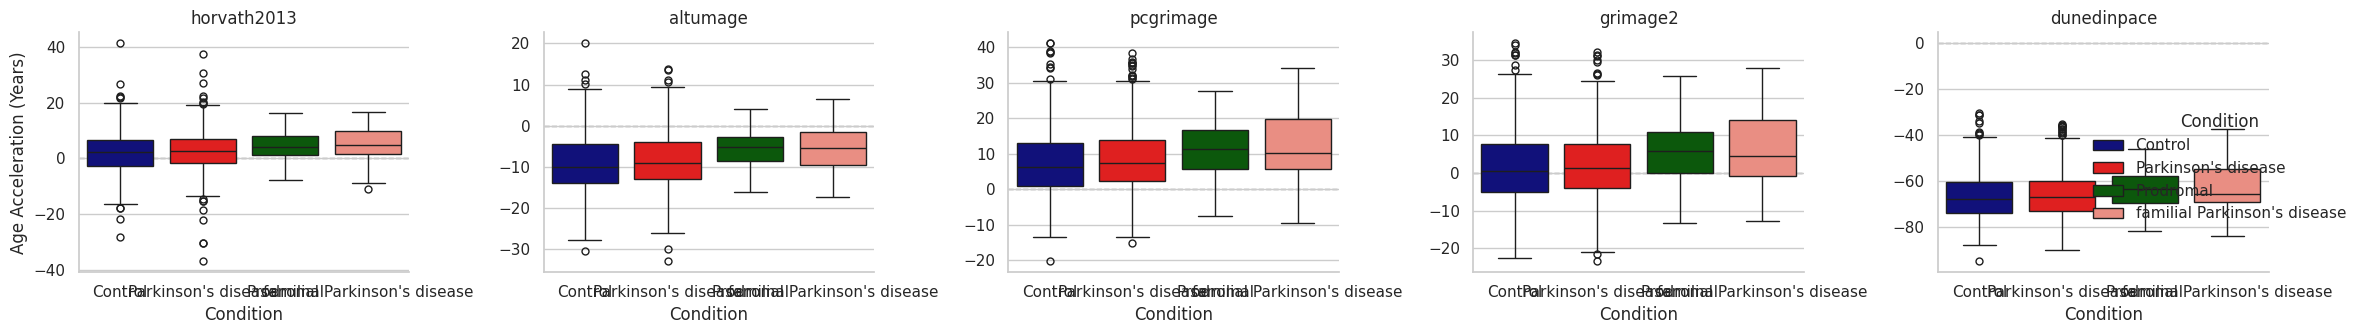

In [15]:
# Age discrepancy

accel_cols = []
for clock in clock_cols:
    accel_col_name = f'{clock}_Accel'
    data_clock[accel_col_name] = data_clock[clock] - data_clock[actual_age_col]
    accel_cols.append(accel_col_name)



df_long = pd.melt(
    data_clock.reset_index(),
    id_vars=['index', actual_age_col, condition_col, donor_col, 'Set', 'Gender'] + clock_cols,
    value_vars=accel_cols,
    var_name='ClockAccelerationType',
    value_name='AgeAcceleration'
)
df_long['ClockAccelerationType'] = df_long['ClockAccelerationType'].str.replace('_Accel', '')


col_wrap_num = 5 
g = sns.catplot(
    data=df_long[(df_long['Gender'] == 'M')],
    x=condition_col, 
    y='AgeAcceleration',
    # hue=condition_col, 
    hue=condition_col,  
    #hue_order=label_order,
    palette=condition_color,
    col='ClockAccelerationType', 
    col_wrap=col_wrap_num,
    kind='box',          
    height=3.5, aspect=1.2,
    legend=True,
    legend_out=True, 
    sharex=True,         
    sharey=False          
)

g.map_dataframe(lambda data, color: plt.axhline(0, color='grey', linestyle='--', lw=1, zorder=0)) # Draw line behind boxes
g.set_axis_labels(f"{condition_col}", "Age Acceleration (Years)")
g.set_titles("{col_name}") 
g.fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()



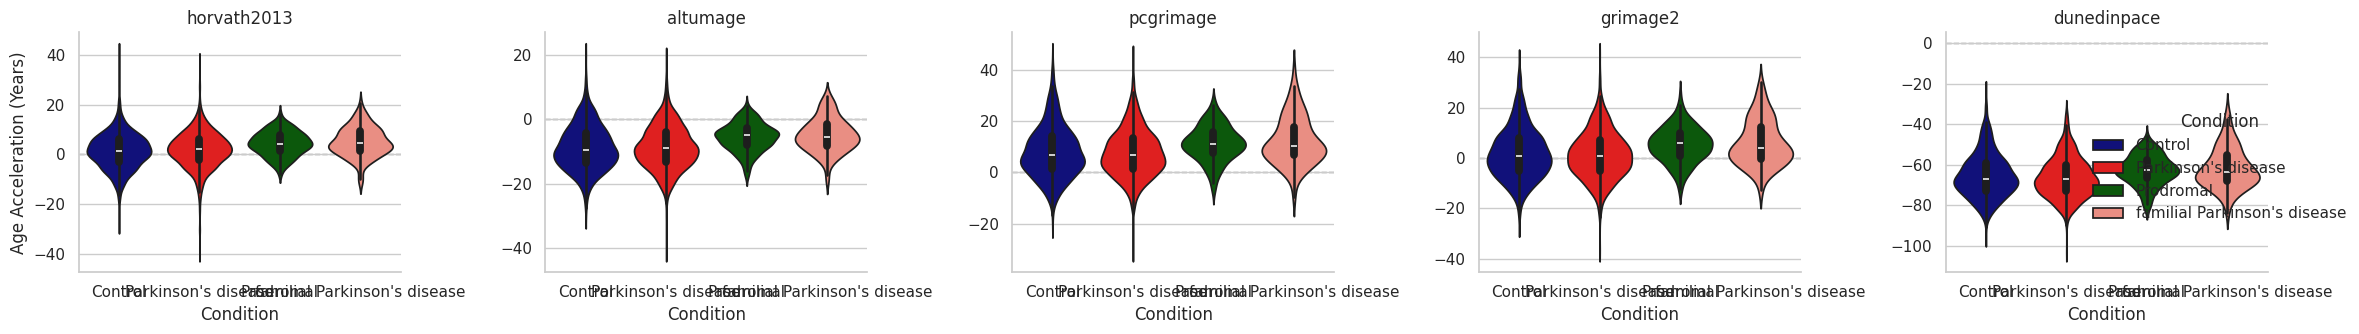

In [16]:
# Age discrepancy


col_wrap_num = 5 
g = sns.catplot(
    data=df_long,
    x=condition_col, 
    y='AgeAcceleration',
    # hue=condition_col, 
    hue=condition_col,  
    #hue_order=label_order,
    palette=condition_color,
    col='ClockAccelerationType',
    col_wrap=col_wrap_num,
    kind='violin',           
    height=3.5, aspect=1.2,
    legend=True,
    legend_out=True, 
    sharex=True,         
    sharey=False          
)

g.map_dataframe(lambda data, color: plt.axhline(0, color='grey', linestyle='--', lw=1, zorder=0))
g.set_axis_labels(f"{condition_col}", "Age Acceleration (Years)")
g.set_titles("{col_name}")
g.fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()


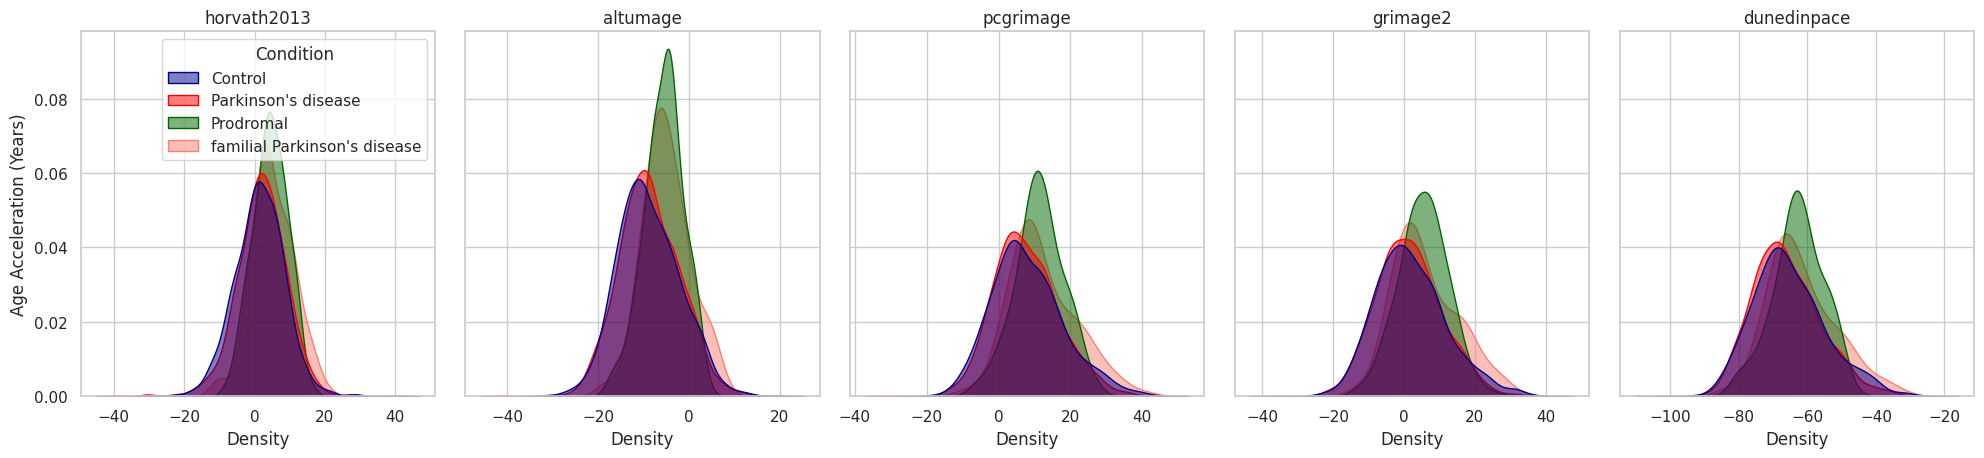

In [17]:
ncols = 5
num_clocks = len(clock_cols)
nrows = math.ceil(num_clocks / ncols) if num_clocks > 0 else 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 5), sharex=False, sharey=True)
axes_flat = axes.flatten()

# --- Loop and create each plot ---
for i, clock in enumerate(clock_cols):
    ax = axes_flat[i]
    
    sns.kdeplot(
        data=df_long[(df_long['ClockAccelerationType'] == clock)],
        x='AgeAcceleration',    
        hue=condition_col,      
        palette=condition_color,
        fill=True,
        alpha=0.5,
        common_norm=False,
        ax=ax,
        legend=(i == 0)
    )
    
    ax.axhline(0, color='grey', linestyle='--', lw=1)
    ax.set_title(clock)
    ax.set_xlabel("Density") 
    
    if i > 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Age Acceleration (Years)")

for j in range(num_clocks, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Altumage

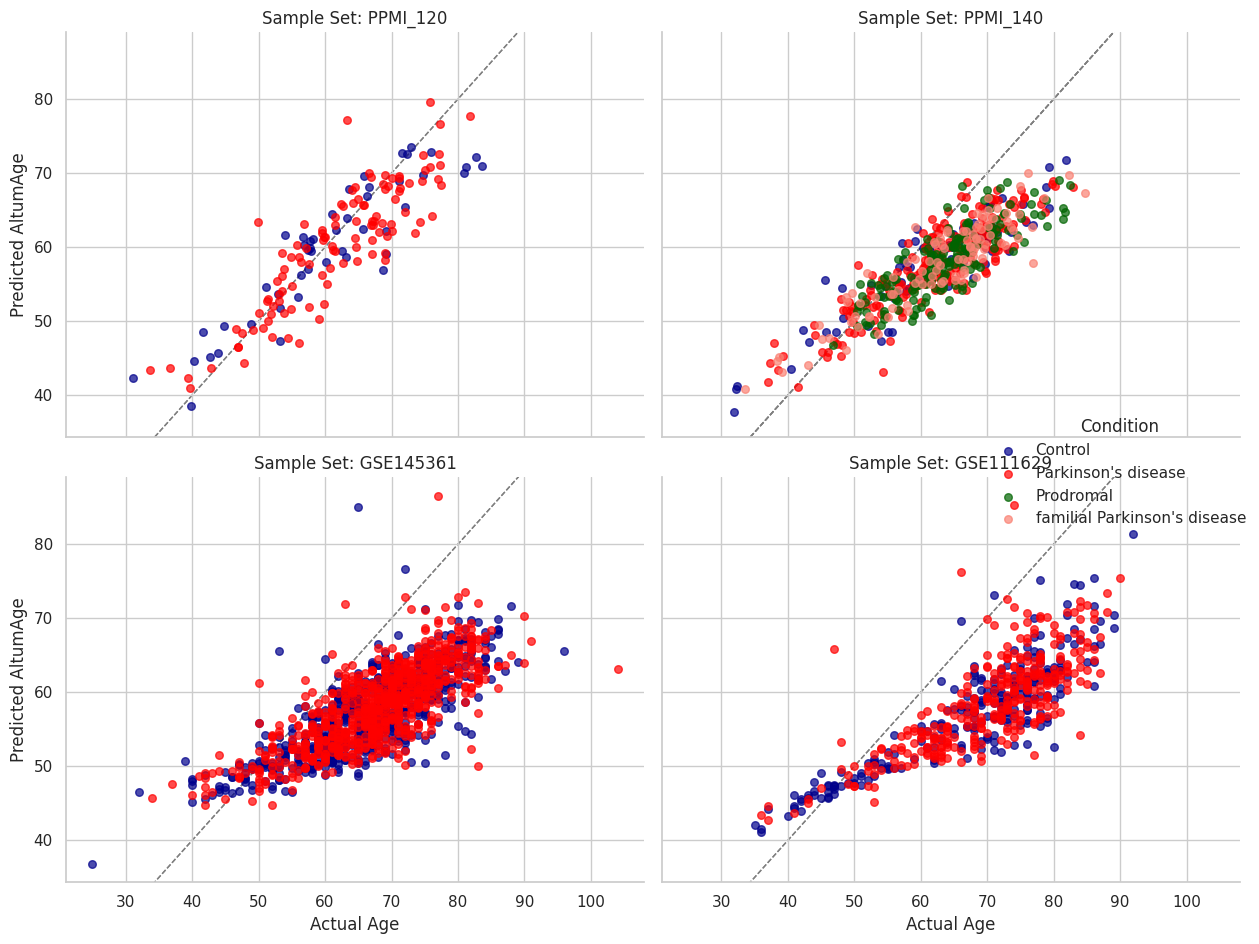

In [18]:
clock = 'altumage'
g = sns.lmplot(
    data=data_clock,
    x=actual_age_col,
    y=clock,
    hue=condition_col,
    col='Set',           
    col_wrap=2,          
    height=5,
    ci=None,             
    palette=condition_color,
    fit_reg=False,
    scatter_kws={'s': 30, 'alpha': 0.7}
)

# Helper function to add the y=x identity line
def plot_identity(x, y, **kwargs):
    ax = plt.gca()
    x_lim = ax.get_xlim(); y_lim = ax.get_ylim()
    plot_min = min(x_lim[0], y_lim[0]); plot_max = max(x_lim[1], y_lim[1])
    ax.plot([plot_min, plot_max], [plot_min, plot_max], color='grey', linestyle='--', lw=1, zorder=0)
    ax.set_xlim(x_lim); ax.set_ylim(y_lim)

g.map_dataframe(plot_identity, x=actual_age_col, y=clock)
g.set_axis_labels("Actual Age", "Predicted AltumAge")
g.set_titles("Sample Set: {col_name}") 
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

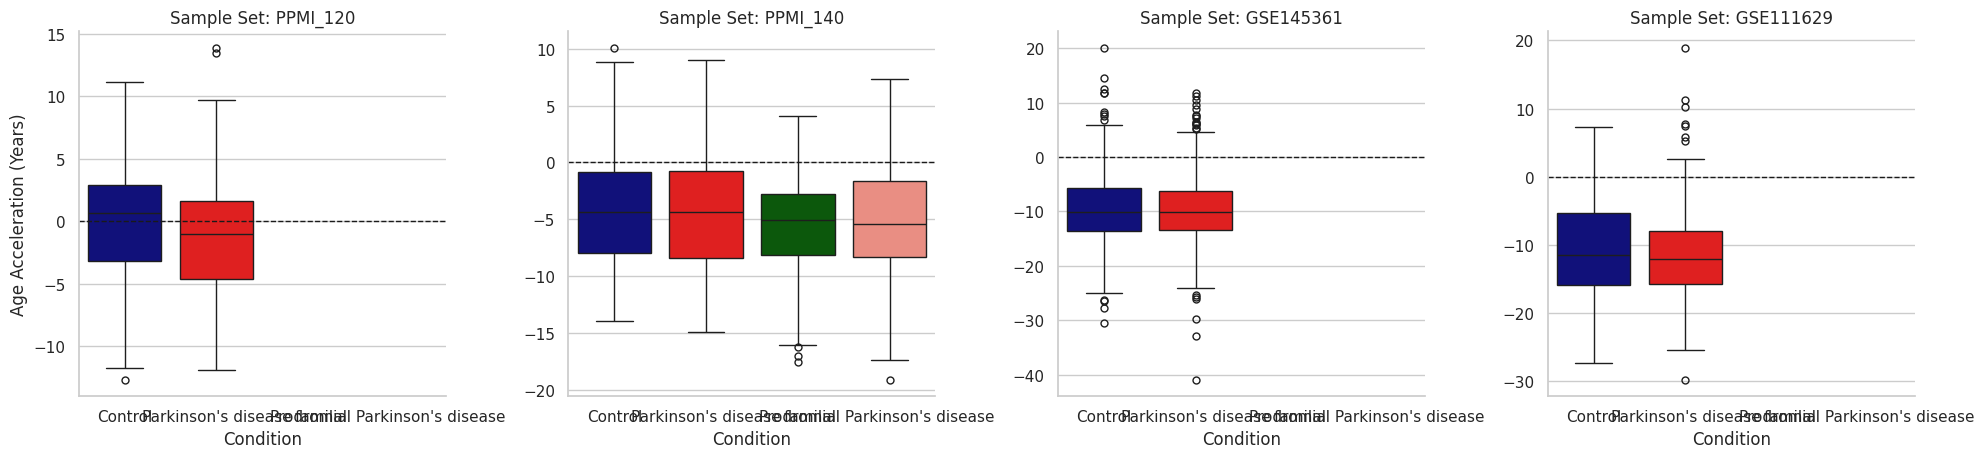

In [19]:
g = sns.catplot(
    data=df_long[df_long['ClockAccelerationType'] == clock],
    x=condition_col,
    y='AgeAcceleration',
    hue=condition_col,
    palette=condition_color,
    col='Set',            
    col_wrap=4,            
    kind='box',             
    height=5, aspect=1,
    legend=False,
    sharey=False            
)

g.map_dataframe(lambda data, color: plt.axhline(0, color='k', linestyle='--', lw=1))
g.set_axis_labels("Condition", "Age Acceleration (Years)")
g.set_titles("Sample Set: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

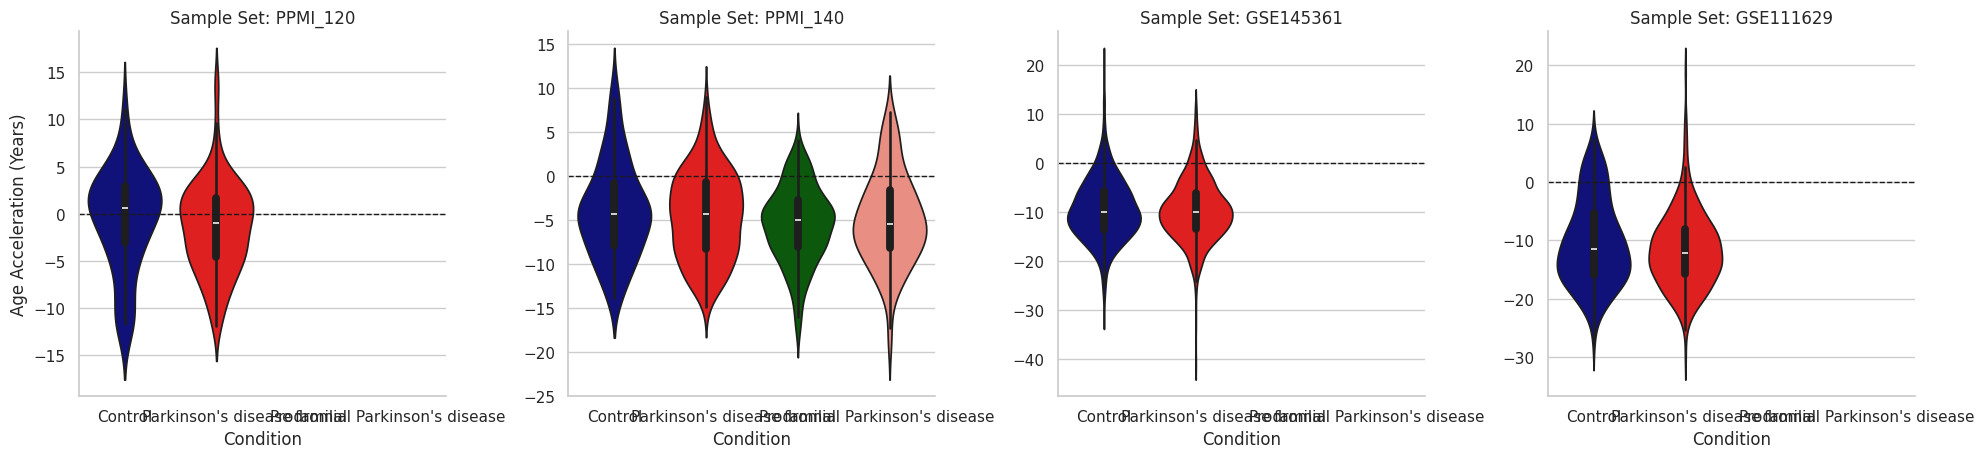

In [20]:
g = sns.catplot(
    data=df_long[df_long['ClockAccelerationType'] == clock],
    x=condition_col,
    y='AgeAcceleration',
    hue=condition_col,
    palette=condition_color,
    col='Set',            
    col_wrap=4,            
    kind='violin',             
    height=5, aspect=1,
    legend=False,
    sharey=False            
)

g.map_dataframe(lambda data, color: plt.axhline(0, color='k', linestyle='--', lw=1))
g.set_axis_labels("Condition", "Age Acceleration (Years)")
g.set_titles("Sample Set: {col_name}")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

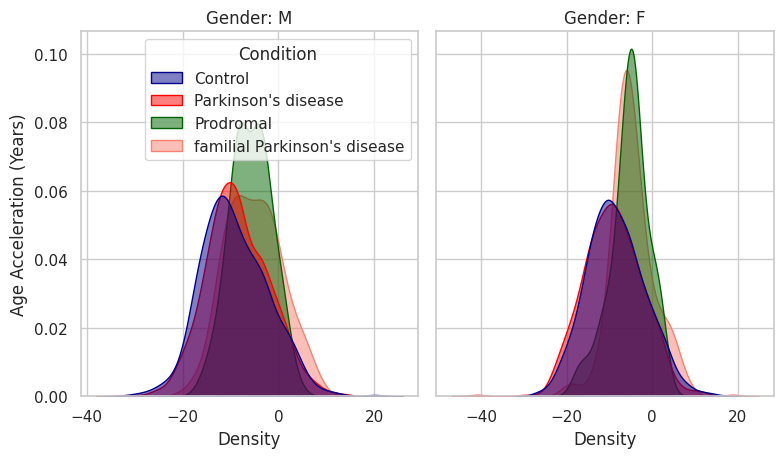

In [21]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 5), sharex=False, sharey=True)
axes_flat = axes.flatten()

# --- Loop and create each plot ---
for i, g in enumerate(['M', 'F']):
    ax = axes_flat[i]
    
    sns.kdeplot(
        data=df_long[(df_long['ClockAccelerationType'] == clock) & 
        (df_long['Gender'] == g)],
        x='AgeAcceleration',    
        hue=condition_col,      
        palette=condition_color,
        fill=True,
        alpha=0.5,
        common_norm=False,
        ax=ax,
        legend=(i == 0)
    )
    
    ax.axhline(0, color='grey', linestyle='--', lw=1)
    ax.set_title(f"Gender: {g}")
    ax.set_xlabel("Density") 
    
    if i > 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("Age Acceleration (Years)")

for j in range(num_clocks, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [22]:
pairs_statistics(data=df_long[df_long['ClockAccelerationType'] == clock], condition_col=condition_col, change_col = 'AgeAcceleration', group1 = 'Control', group2="Parkinson's disease")

Number of Ctrl donors: 1018
Number of PD donors:   1371

Checking assumptions (results printed for info):
  Normality (Shapiro-Wilk): Ctrl p-value=0.000, PD p-value=0.000
  Note: At least one group may not be normally distributed (p <= 0.05).
  Equal Variance (Levene): p-value=0.345

Performing Mann-Whitney U test (non-parametric)...
  Mann-Whitney U statistic: 685556.000
  P-value: 0.4613
  Result: No significant difference found between Ctrl and PD distributions (p >= 0.05).

Performing Independent Two-Sample T-test (Student's t-test, parametric)...
  T-statistic: -0.379
  P-value: 0.7050
  Result: No significant difference found between Ctrl and PD means (p >= 0.05).

--- Interpretation Guidance ---
Choose the test result based on assumptions:
- If data is NOT normally distributed (especially with small N), prefer Mann-Whitney U.
- If data IS normally distributed:
  - Use T-test result.
  - If variances were unequal (Levene p <= 0.05), Welch's t-test (equal_var=False) was used.
  - 

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
clock = 'altumage'
groups_to_compare = ['Control', "Parkinson's disease"]
df_subset = df_long[
    (df_long['ClockAccelerationType'] == clock) & 
    (df_long[condition_col].isin(groups_to_compare))
]

# 2. Define the model formula

model_formula = f"AgeAcceleration ~ C({condition_col}) + C(Gender)"

# 3. Fit the linear model and get the ANOVA table
model = smf.ols(formula=model_formula, data=df_subset).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# 4. Print the result
print(f"--- ANOVA Results for {clock} (Control vs. Parkinson's disease) ---")
print(anova_table)

--- ANOVA Results for altumage (Control vs. Parkinson's disease) ---
                     sum_sq      df         F    PR(>F)
C(Condition)      14.871369     3.0  0.106631  0.744041
C(Gender)          8.890459     1.0  0.191240  0.661926
Residual      110921.333321  2386.0       NaN       NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


## Longitudinal set (PPMI_140)

In [26]:
data_clock = data_clock_backup.copy()

In [27]:
data_clock[data_clock['Set'] == 'PPMI_140']['EVENT_ID'].unique()

array(['V04', 'BL', 'V06', 'V08'], dtype=object)

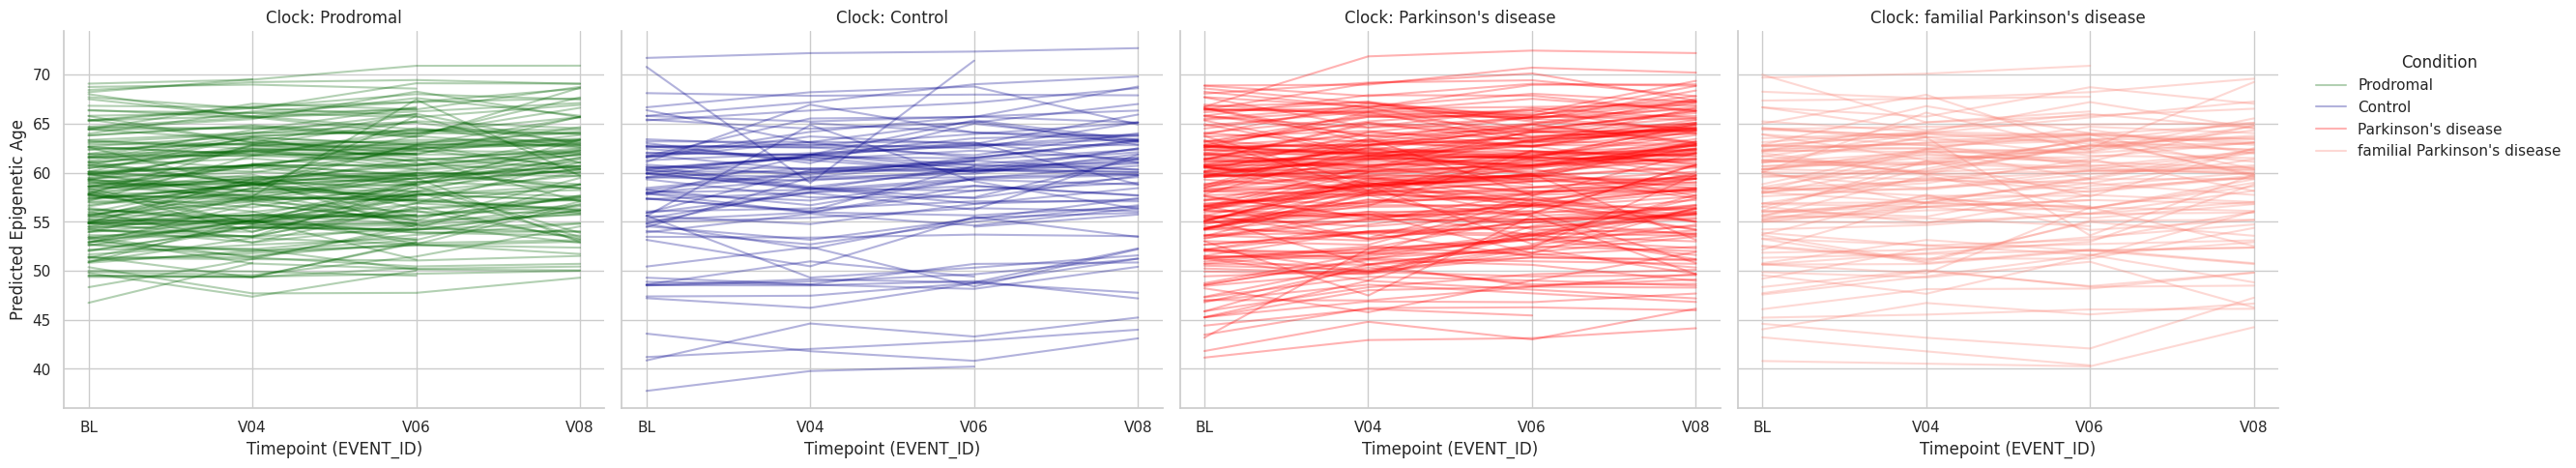

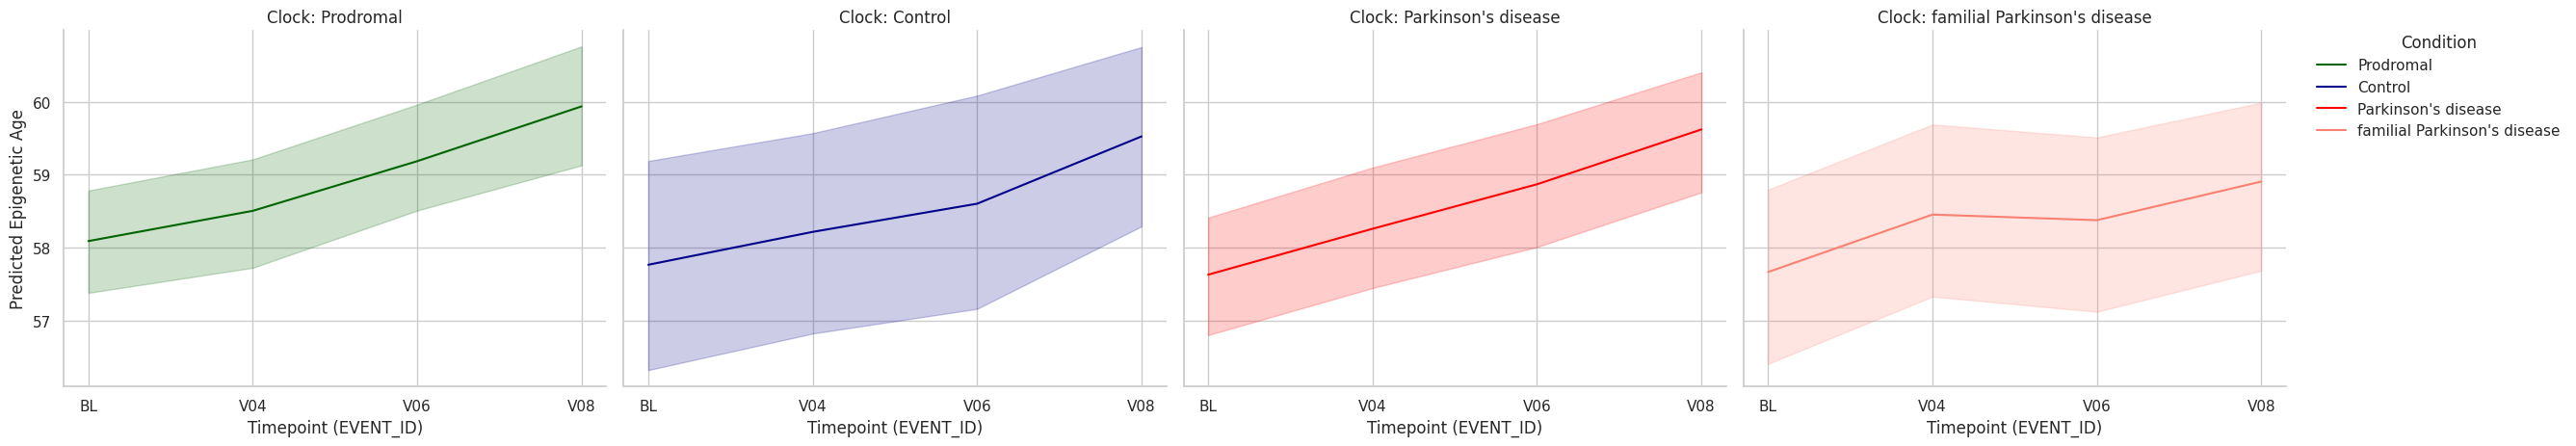

In [28]:
# Subset data to only the desired sample set
ppmi_140_df = data_clock[data_clock['Set'] == 'PPMI_140'].copy()
timepoint_col = 'EVENT_ID'
id_vars_to_keep = [donor_col, condition_col, timepoint_col, 'Gender']
df_longitudinal = pd.melt(
    ppmi_140_df,
    id_vars=id_vars_to_keep,
    value_vars=clock_cols,
    var_name='ClockType',
    value_name='PredictedAge'
)

# Ensure timepoints are plotted in the correct chronological order
timepoint_order = ['BL', 'V04', 'V06', 'V08'] 
df_longitudinal[timepoint_col] = pd.Categorical(df_longitudinal[timepoint_col], categories=timepoint_order, ordered=True)

clock = 'altumage'

# Create the Longitudinal Plot
g = sns.relplot(
    data=df_longitudinal[(df_longitudinal['ClockType'] == clock) ],
    x=timepoint_col,
    y='PredictedAge',
    hue=condition_col,          
    col=condition_col,           
    kind='line',               
    units=donor_col,            
    estimator=None,             
    height=5, aspect=1.2,
    palette=condition_color,
    alpha=0.3,                 
    legend=True                
)
# Move the legend generated by the second plot
sns.move_legend(g, "upper left", bbox_to_anchor=(0.9, 0.9))

h = sns.relplot(
    data=df_longitudinal[(df_longitudinal['ClockType'] == clock)],
    x=timepoint_col,
    y='PredictedAge',
    hue=condition_col,
    col=condition_col,
    kind='line',    
    height=5, aspect=1.2,
    palette=condition_color,
    legend="full"
)

# Move the legend generated by the second plot
sns.move_legend(h, "upper left", bbox_to_anchor=(0.9, 0.9))

# Final customizations
g.set_axis_labels("Timepoint (EVENT_ID)", "Predicted Epigenetic Age")
g.set_titles("Clock: {col_name}")
h.set_axis_labels("Timepoint (EVENT_ID)", "Predicted Epigenetic Age")
h.set_titles("Clock: {col_name}")
plt.tight_layout(rect=[0, 0, 0.9, 0.96])
plt.show()

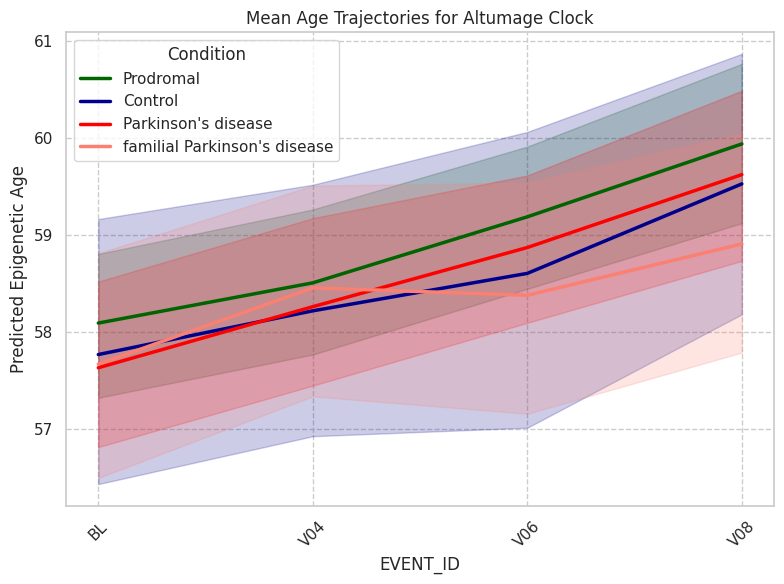

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    data=df_longitudinal[df_longitudinal['ClockType'] == clock],
    x=timepoint_col,
    y='PredictedAge',
    hue=condition_col,          
    palette=condition_color,
    ax=ax,
    linewidth=2.5,
    errorbar='ci'               
)

# 4. Final customizations
ax.set_title(f'Mean Age Trajectories for {clock.title()} Clock')
ax.set_ylabel("Predicted Epigenetic Age")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='both', linestyle='--')
ax.legend(title='Condition')
plt.tight_layout()
plt.show()

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

timepoint_in_years_map = {
    'BL': 0,
    'V04': 1,
    'V06': 2,
    'V08': 3
}

# Create a new numeric time column
df_longitudinal['TimeInYears'] = df_longitudinal[timepoint_col].map(timepoint_in_years_map)

# Filter for relevant groups
conditions_to_compare = ['Control', "Parkinson's disease"]
df_filtered = df_longitudinal[df_longitudinal[condition_col].isin(conditions_to_compare)].copy()

# For the model, code the condition numerically
df_filtered['Condition_code'] = (df_filtered[condition_col] == "Parkinson's disease").astype(int)


# Statistical Test (Stratified by Gender)

genders_to_test = df_filtered['Gender'].unique()
for gender in genders_to_test:
    print("\n" + "="*50)
    print(f"ANALYSIS FOR GENDER: {gender}")
    print("="*50)
    
    df_gender_subset = df_filtered[df_filtered['Gender'] == gender]

    
    print(f"\n--- Statistical Analysis for: {clock} (Gender: {gender}) ---")
    
    df_final_subset = df_gender_subset[df_gender_subset['ClockType'] == clock]
    
    model_formula = "PredictedAge ~ TimeInYears * C(Condition_code)"
    try:
        
        model = smf.ols(formula=model_formula, data=df_final_subset).fit()
        print(model.summary())
        # --- More Robust P-Value Retrieval ---
        interaction_p_value = None
        # Search for the interaction term name in the results
        for term in model.pvalues.index:
            if 'TimeInYears' in term and ':C(Condition_code)' in term:
                interaction_p_value = model.pvalues[term]
                break # Stop once found
        
        print(f"\n--- Interpretation for {clock} (Gender: {gender}) ---")
        if interaction_p_value is not None:
            print(f"P-value for the interaction (difference in slopes): {interaction_p_value:.4f}")
            alpha = 0.05
            if interaction_p_value < alpha:
                print(f"Conclusion: There is a STATISTICALLY SIGNIFICANT difference in the rate of change between groups (p < {alpha}).")
            else:
                print(f"Conclusion: There is NO significant difference in the rate of change between groups (p >= {alpha}).")
        else:
            # This message will now appear only if the term was truly dropped from the model summary
            print("Conclusion: Could not test for a difference in slopes. The interaction term was likely dropped by the model due to insufficient data for both groups across multiple timepoints.")

    except Exception as e:
        print(f"Could not fit model for {clock} (Gender: {gender}). Error: {e}")



ANALYSIS FOR GENDER: F

--- Statistical Analysis for: altumage (Gender: F) ---
                            OLS Regression Results                            
Dep. Variable:           PredictedAge   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.5690
Date:                Wed, 02 Jul 2025   Prob (F-statistic):              0.781
Time:                        08:27:09   Log-Likelihood:                -1121.9
No. Observations:                 347   AIC:                             2260.
Df Residuals:                     339   BIC:                             2291.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [31]:

print(f"\n--- Statistical Analysis for: {clock} ---")
# Filter for relevant groups
conditions_to_compare = ['Control', "Parkinson's disease"]
df_filtered = df_longitudinal[df_longitudinal[condition_col].isin(conditions_to_compare)].copy()

# For the model, code the condition numerically
df_filtered['Condition_code'] = (df_filtered[condition_col] == "Parkinson's disease").astype(int)
df_final_subset = df_filtered[df_filtered['ClockType'] == clock]

model_formula = "PredictedAge ~ TimeInYears * C(Condition_code)"
try:
    
    model = smf.ols(formula=model_formula, data=df_final_subset).fit()
    print(model.summary())
    # --- More Robust P-Value Retrieval ---
    interaction_p_value = None
    # Search for the interaction term name in the results
    for term in model.pvalues.index:
        if 'TimeInYears' in term and ':C(Condition_code)' in term:
            interaction_p_value = model.pvalues[term]
            break # Stop once found
    
    print(f"\n--- Interpretation for {clock} ---")
    if interaction_p_value is not None:
        print(f"P-value for the interaction (difference in slopes): {interaction_p_value:.4f}")
        alpha = 0.05
        if interaction_p_value < alpha:
            print(f"Conclusion: There is a STATISTICALLY SIGNIFICANT difference in the rate of change between groups (p < {alpha}).")
        else:
            print(f"Conclusion: There is NO significant difference in the rate of change between groups (p >= {alpha}).")
    else:
        # This message will now appear only if the term was truly dropped from the model summary
        print("Conclusion: Could not test for a difference in slopes. The interaction term was likely dropped by the model due to insufficient data for both groups across multiple timepoints.")

except Exception as e:
    print(f"Could not fit model for {clock}. Error: {e}")


--- Statistical Analysis for: altumage ---
                            OLS Regression Results                            
Dep. Variable:           PredictedAge   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.164
Date:                Wed, 02 Jul 2025   Prob (F-statistic):             0.0351
Time:                        08:27:09   Log-Likelihood:                -3408.5
No. Observations:                1062   AIC:                             6833.
Df Residuals:                    1054   BIC:                             6873.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

# Export figures

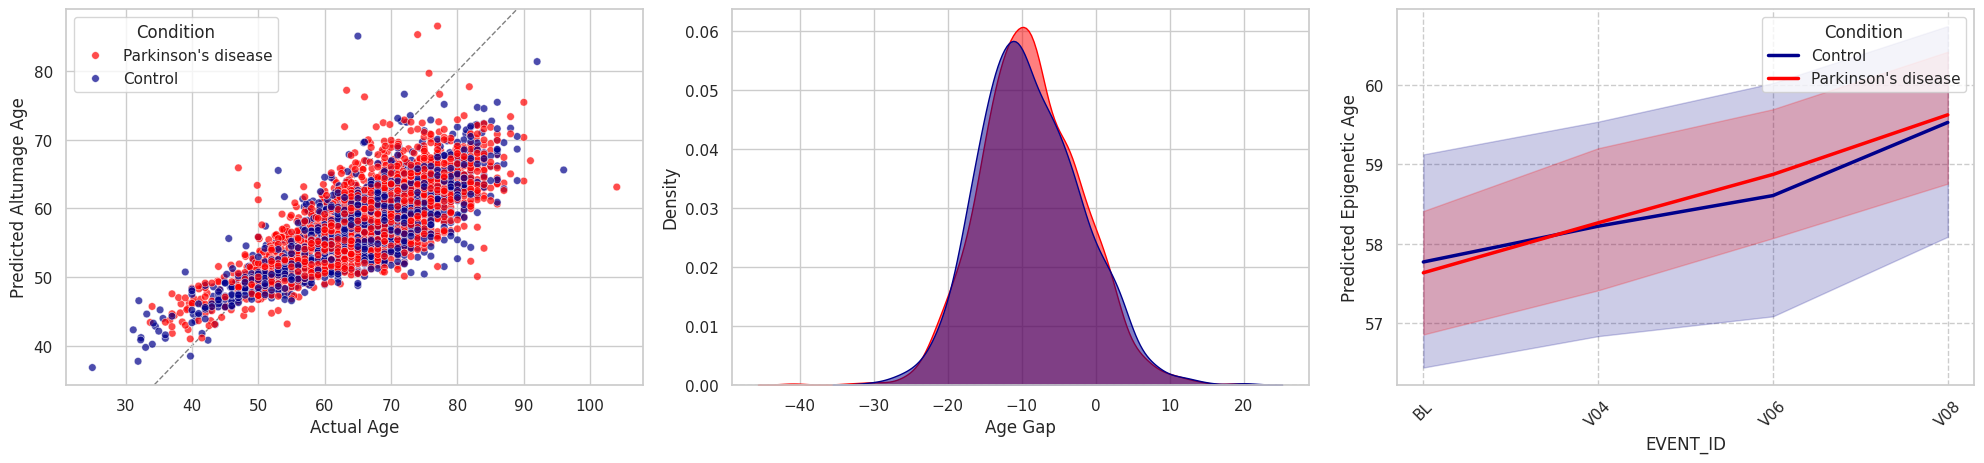

In [34]:


clock = 'altumage'
conditions_to_keep = ['Control', "Parkinson's disease"]


# Create Figure and Axes
fig = plt.figure(figsize=(20, 5)) # 2 rows, 3 columns

# Define the grid structure with width ratios
# Make the middle column (index 1) narrower, e.g., 70% of the others
gs = gridspec.GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1], height_ratios=[1])

# Create axes individually using the grid spec
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1]) 
ax02 = fig.add_subplot(gs[0, 2])



# Row 1, Col 1: Scatter Plot (Predicted vs Actual)
ax = ax00
sns.scatterplot(
    data=data_clock[data_clock[condition_col].isin(conditions_to_keep)],
    x=actual_age_col,
    y=clock,
    hue=condition_col,
    palette=condition_color,
    s=30, alpha=0.7,
    ax=ax,
    legend=True
)


x_lim = ax.get_xlim(); y_lim = ax.get_ylim()
plot_min = min(x_lim[0], y_lim[0]); plot_max = max(x_lim[1], y_lim[1])
ax.plot([plot_min, plot_max], [plot_min, plot_max], color='grey', linestyle='--', lw=1, zorder=0)
ax.set_xlim(x_lim); ax.set_ylim(y_lim)
ax.set_xlabel("Actual Age")
ax.set_ylabel(f"Predicted {clock.title()} Age")

# Row 1, Col 2: Box Plot 
ax = ax01
# Use kdeplot with hue='Condition' to create the 4 separate curves
sns.kdeplot(
    data=df_long[(df_long['ClockAccelerationType'] == clock) &
    (df_long[condition_col].isin(conditions_to_keep))],
    x='AgeAcceleration',    
    hue=condition_col,      
    palette=condition_color,
    fill=True,
    alpha=0.5,
    common_norm=False,
    ax=ax,
    legend=(i == 0) # Only show legend on the first plot
)

ax.axhline(0, color='grey', linestyle='--', lw=1)
ax.set_xlabel("Age Gap") 



# Row 1, Col 3: Bar Plot (Change lt - st per Donor)
ax = ax02
sns.lineplot(
    data=df_longitudinal[
    (df_longitudinal['ClockType'] == clock) &
    (df_longitudinal[condition_col].isin(conditions_to_keep))],
    x=timepoint_col,
    y='PredictedAge',
    hue=condition_col,          
    palette=condition_color,
    ax=ax,
    linewidth=2.5,
    errorbar='ci'               
)

# 4. Final customizations
ax.set_ylabel("Predicted Epigenetic Age")
ax.tick_params(axis='x', rotation=45)
ax.grid(True, which='both', linestyle='--')
ax.legend(title='Condition')




plt.tight_layout(rect=[0, 0, 1, 0.96]) 
filename_fig = ('Blood_AltumAge_clock.svg')
plt.savefig(os.path.join(figureDir, filename_fig))
filename_fig = ('Blodd_AltumAge_clock.pdf')
plt.savefig(os.path.join(figureDir, filename_fig))
plt.show()
